In [1]:
import pandas as pd
import re
import os
import networkx as nx
import matplotlib.pyplot as plt
import json

In [2]:
#parameters
#file_path_list = ['BundleSheets/Mapping pozycji.txt', 'BundleSheets/Mapping2023.txt','BundleSheets/Cenniki merchantów 2023.txt']
# Define the path to your directory
directory_path = 'BundleSheets/'

# List all files in the directory and filter for .txt files
file_path_list = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.txt')]


## Sheet relations

In [3]:
sheet_relations={}

for file_path in file_path_list:
    # Read the content of the newly uploaded file
    with open(file_path, 'r', encoding='utf-8') as newest_file:
        newest_file_content = newest_file.read()

    # Find sheet names in the new file's content
    newest_sheet_names = re.findall(";'?[A-Za-z0-9\sąćęłńóśżźĄĆĘŁŃÓŚŻŹ]+'?!", newest_file_content)


    # Remove duplicates by converting the list to a set, then back to a list
    clean_newest_sheet_names= [item.replace('\'','').replace('!','').replace(';','') for item in newest_sheet_names]
    unique_newest_sheet_names=list(set(clean_newest_sheet_names))
    
    # Add do dictonary
    sheet_name = file_path.split('/')[-1].replace('.txt', '')
    sheet_relations[sheet_name]=unique_newest_sheet_names

In [4]:
sheet_relations

{'2023 MASTER SHEET': ['Score2023',
  'Sprawdzenie',
  'RevenueL9M',
  'Rentowność2023',
  'Mapping2023'],
 'Cenniki merchantów 2023': ['Mapping2023',
  'Mapping pozycji',
  'Pozostałe pozycje merchantów 2023'],
 'Mapping pozycji': [],
 'Mapping2023': ['Sprawdzenie'],
 'MASTER SHEET': [],
 'Pozostałe pozycje merchantów 2023': ['Mapping pozycji',
  'Cenniki merchantów'],
 'Rentowność2023': [],
 'RentownośćPerKurier2023': [],
 'Szablon wyliczenia PL': ['Pozycje do zmiany',
  'Mapping',
  'Wyliczenia kurierów 2023',
  'Marża kurier2024',
  'Pozostałe pozycje merchantów 2023',
  'MASTER SHEET',
  'Mapping pozycji',
  'RevenueL9M',
  'RentownośćPerKurier2023',
  'Rentowność2023',
  '2023 MASTER SHEET',
  'Cenniki merchantów 2023',
  'Mapping2023'],
 'Wyliczenia kurierów 2023': ['Mapping', 'Marża kurier']}

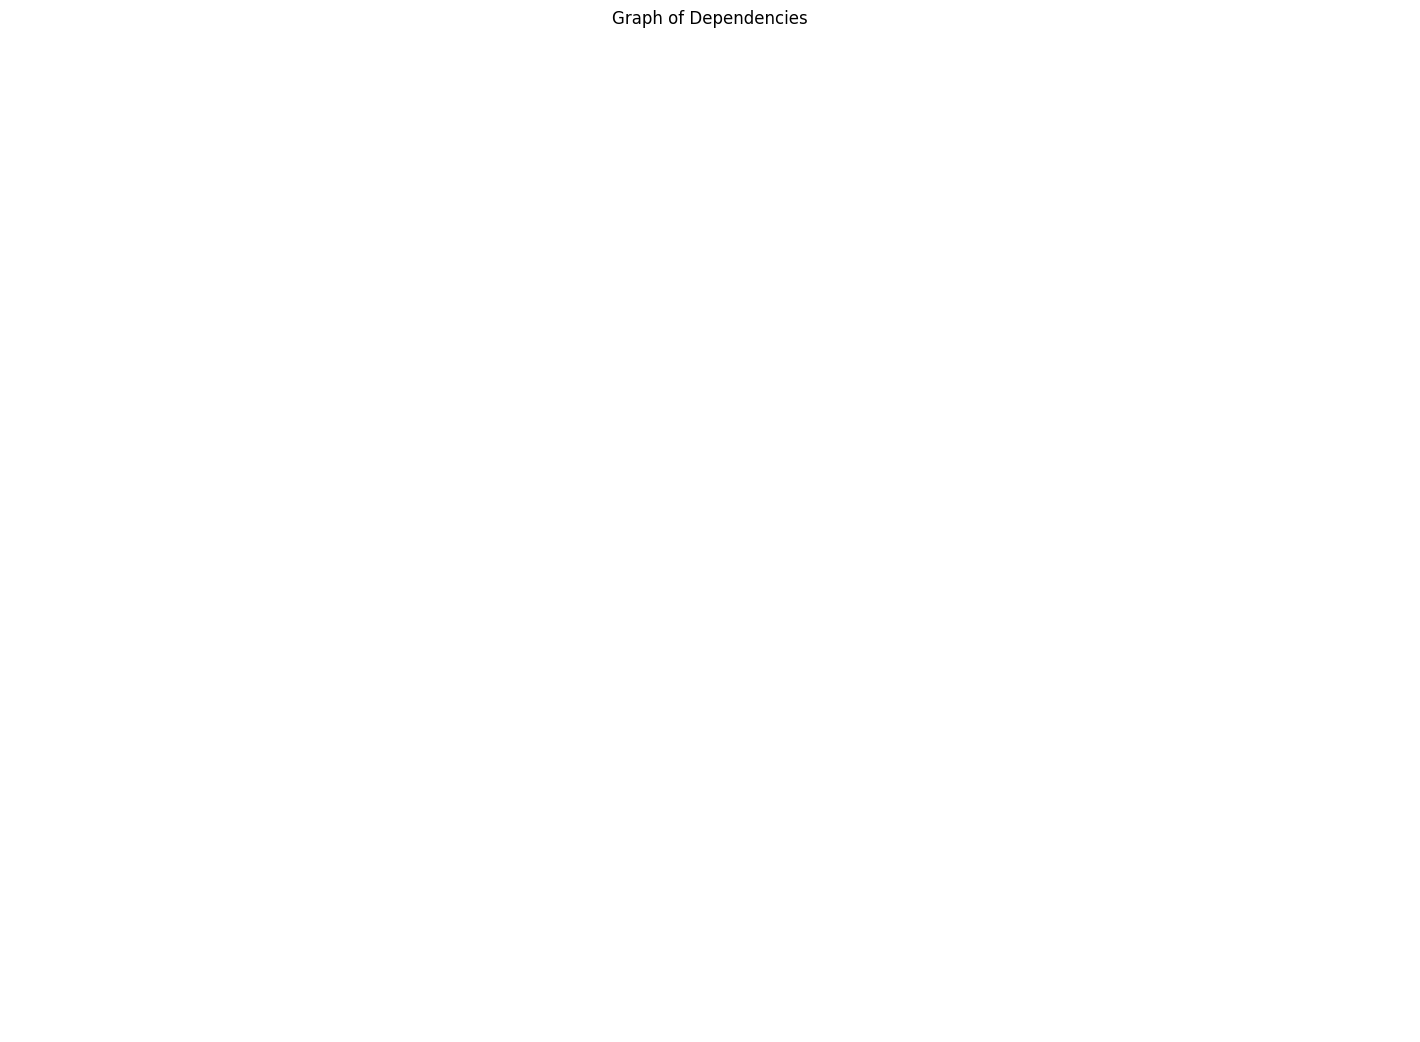

In [5]:
#func
sheet_name='Marża kurier'

# Create a directed graph from dependencies
G = nx.DiGraph()

# Add nodes and edges from the dependencies
for source, targets in sheet_relations.items():
    if source == sheet_name:
        G.add_node(source)  # Ensure all sources are added as nodes
        for target in targets:
            # Simplify target names to match source formatting for demonstration
            simplified_target = target
            G.add_edge(source, simplified_target)

# Draw the graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42)  # For consistent layout
nx.draw(G, pos, with_labels=True, arrows=True, node_size=20000, node_color='lightblue', font_size=10, font_weight='bold')
plt.title('Graph of Dependencies')
plt.show()

## Sheet and columns realation

In [6]:
def excel_column_name(n):
    """Generate Excel-like column names, given a column index starting from 1."""
    name = ''
    while n > 0:
        n, remainder = divmod(n - 1, 26)
        name = chr(65 + remainder) + name
    return name


sheet_relations_col = {}

for file_path in file_path_list:
    # Read the file as a CSV with tab as the separator
    df = pd.read_csv(file_path, sep='\t', encoding='utf-8')
    
    # Initialize a temporary dictionary to hold references for the current sheet with Excel-like column names
    current_sheet_references = {excel_column_name(i+1): set() for i in range(len(df.columns))}
    
    for i, col in enumerate(df.columns, start=1):
        excel_col_name = excel_column_name(i)  # Get the Excel-like column name
        
        for cell in df[col]:
            if pd.notnull(cell):  # Check if the cell is not NaN
                # Find all references to other sheets in the cell
                matches = re.findall(r";'?[A-Za-z0-9\sąćęłńóśżźĄĆĘŁŃÓŚŻŹ]+'?!", str(cell))
                
                # Clean up the matches and add to the set for the column
                clean_matches = {match.replace('\'', '').replace('!', '').replace(';', '') for match in matches}
                current_sheet_references[excel_col_name].update(clean_matches)
    
    # Remove empty entries and compile references across all columns for the current sheet
    sheet_references = {col: list(refs) for col, refs in current_sheet_references.items() if refs}
    
    # Extract the sheet name from the file path and add to the main dictionary
    sheet_name = file_path.split('/')[-1].replace('.txt', '')
    sheet_relations_col[sheet_name] = sheet_references

In [8]:
# Output the collected relations
# Define the filename where you want to save the dictionary
filename = 'SheetRelationCol.json'

# Open the file in write mode ('w') and serialize the dictionary to JSON
with open(filename, 'w') as json_file:
    json.dump(sheet_relations_col, json_file, indent=4)

sheet_relations_col #dict

{'2023 MASTER SHEET': {'B': ['Sprawdzenie'],
  'C': ['Score2023'],
  'D': ['Mapping2023'],
  'G': ['Sprawdzenie'],
  'H': ['Mapping2023'],
  'I': ['RevenueL9M'],
  'L': ['Rentowność2023']},
 'Cenniki merchantów 2023': {'H': ['Mapping pozycji'],
  'K': ['Mapping2023'],
  'L': ['Mapping pozycji'],
  'M': ['Mapping pozycji'],
  'P': ['Mapping2023'],
  'V': ['Pozostałe pozycje merchantów 2023']},
 'Mapping pozycji': {},
 'Mapping2023': {'G': ['Sprawdzenie'],
  'J': ['Sprawdzenie'],
  'L': ['Sprawdzenie'],
  'CQ': ['Sprawdzenie']},
 'MASTER SHEET': {},
 'Pozostałe pozycje merchantów 2023': {'L': ['Mapping pozycji'],
  'M': ['Mapping pozycji'],
  'T': ['Cenniki merchantów']},
 'Rentowność2023': {},
 'RentownośćPerKurier2023': {},
 'Szablon wyliczenia PL': {'A': ['2023 MASTER SHEET'],
  'B': ['Mapping pozycji'],
  'C': ['Mapping pozycji'],
  'E': ['Mapping2023'],
  'F': ['Mapping',
   'Wyliczenia kurierów 2023',
   'Cenniki merchantów 2023',
   'Pozostałe pozycje merchantów 2023'],
  'K': ['R

In [ ]:

#func
sheet_name='2023 MASTER SHEET'

# Create a directed graph from dependencies
G = nx.DiGraph()

# Add nodes and edges from the dependencies
for source, targets in sheet_relations_col.items():
    if source == sheet_name:
        G.add_node(source)  # Ensure all sources are added as nodes
        for col, linked_sheet in targets.items():
            # Simplify target names to match source formatting for demonstration
            simplified_target = col
            edge_label = '\n'.join(linked_sheet)
            G.add_edge(source, simplified_target, label=edge_label)

# Draw the graph
plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, seed=42)  # For consistent layout

nx.draw(G, pos, with_labels=True, arrows=True, node_size=7000, node_color='lightblue', font_size=10, font_weight='bold')
# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
#wrapped_edge_labels = wrap_labels(edge_labels, width=15)  # Adjust 'width' as needed

nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

plt.title(sheet_name)
plt.show()



